In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]
import seaborn as sns

from nltk import word_tokenize,Counter,FreqDist
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity #Cosine included in spacy

import warnings
warnings.filterwarnings('ignore')

#from collections import Counter

In [2]:
# reading the data
#from google.colab import files
#data = files.upload()
data = pd.read_csv('beer_reviews.csv')

# removing nulls
data = data.dropna().reset_index(drop=True)
data.isnull().sum()

# taking latest 6000 comments only
#print(len(data))
data = data.tail(len(data))
data.reset_index(drop=True, inplace=True)

# lowering the review for consistency
data['product_review'] = data['product_review'].str.lower()

#Data cleaning
data.drop([data.columns[0]],axis=1,inplace=True)
data.head()

,product_name,product_review,user_rating
0,Kentucky Brunch Brand Stout,"long time waiting to tick this one, and i have...",4.56
1,Kentucky Brunch Brand Stout,this review is for the 2019 batch. it was bott...,5.00
2,Kentucky Brunch Brand Stout,supreme maple od! soooo easy drinking & well-t...,5.00
3,Kentucky Brunch Brand Stout,i have now had 4 different years of kbbs and c...,5.00
4,Kentucky Brunch Brand Stout,2020 bottle. absolutely bonkers maple syrup o...,5.00


In [3]:
data.shape

(6226, 3)

In [4]:
data.isnull().sum()

product_name      0
product_review    0
user_rating       0
dtype: int64

### Task B - Find attributes

In [5]:
import nltk
#nltk.download('averaged_perceptron_tagger')
#Do we need spell-check and lemmatization below?

In [6]:
# creating the text from comments 

data['product_review'] = data['product_review'].str.replace(r'[^\w\s]+', '') #If quote needs to be removed, else considered in tokenization
text = ' '.join(data['product_review'])

#Create function
def getAttribute(text):


    # getting stopword list from nltk
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    #print(stopwords_dict)

    #text = text.replace("'","")
    text_nostop = ' '.join([word for word in text.split() if word not in stopwords_dict])
    text_nostop = "".join(l for l in text_nostop if l not in string.punctuation)
    text_nostop
    #print(text_nostop)

    # tokenizing words
    text_token = word_tokenize(text_nostop)
    #print(text_token[0:10])
    
    #Word Frequency analysis
    fdist1 = FreqDist(text_token)
    filtered_word_freq = dict((word, freq) for word, freq in fdist1.items() if not word.isdigit())
    #print(filtered_word_freq)
    sorted_dict = {k: v for k, v in sorted(filtered_word_freq.items(),reverse=True, key=lambda x: x[1])}
    #print(sorted_dict)
    
    #Extract attributes
    tagged_tokens = nltk.pos_tag(sorted_dict.keys())
    #print(tagged_tokens)
    
    #Attributes
    adj = [token[0] for token in tagged_tokens if token[1] in ['JJ']]
    #print(adj)
    
    #Filtered sorted dict
    sorted_dict_fil = {k:v for k,v in sorted_dict.items() if k in adj}
    #print(sorted_dict_fil)
    
    return adj, sorted_dict_fil


In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
adj, sorted_dict_fil = getAttribute(text=text)
df = pd.DataFrame([sorted_dict_fil]).T.rename({0:'Freq'},axis=1)
df.reset_index().to_csv('Token Frequency.csv')
df.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Freq
dark,2739
nice,2057
good,1959
light,1830
finish,1806
bottle,1705
body,1638
overall,1617
black,1578
white,1563


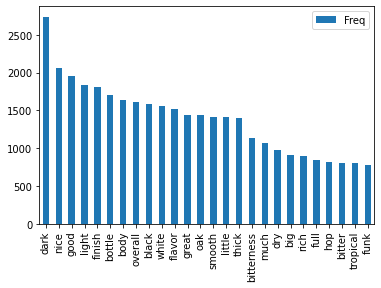

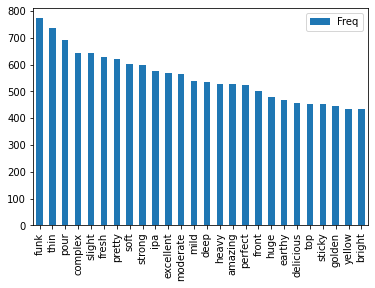

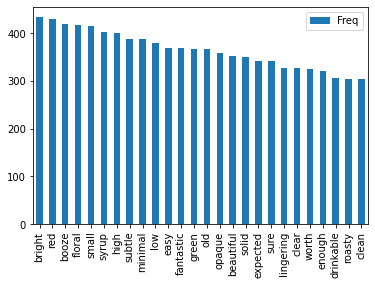

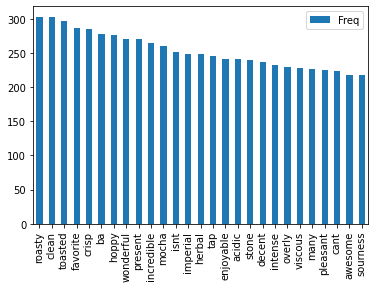

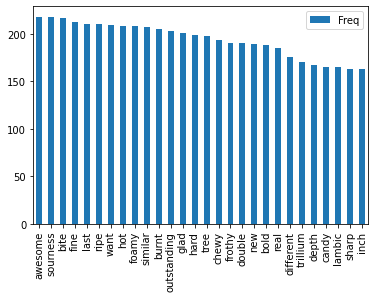

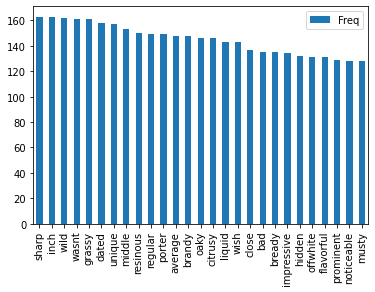

In [8]:
#Plot word frequency
for i in range(6):
    df[(df['Freq'] >= df['Freq'][25*(i+1)]) & (df['Freq'] <= df['Freq'][25*i])].plot(kind='bar')


We avail the following beer-related attributes using the word frequency. We could enrich the analysis by further lemmatizing the tokens but above word frequency plots are able to provide us with a good idea around the types of beers we see in customer reviews.


1.   Taste : Bitter, Delicious, Sourness, Musty <br>
2.   Body : Light, Dark, Black, White, <br>
3.   Texture : Smooth, Thick, Creamy, Dry, Viscous <br>
4. Color : Black, White, Golden, Yellow
5. Type : Sweet, Dry (Malty), Hop, Herbal, Bold, Lambic, Grassy, Oaky, Citrusy


Given all above are adjectives, we can use them all as the attributes of beer provided at a customer level to enrich cosine similarity scores.





In [9]:
data.head(10)

,product_name,product_review,user_rating
0,Kentucky Brunch Brand Stout,long time waiting to tick this one and i have ...,4.56
1,Kentucky Brunch Brand Stout,this review is for the 2019 batch it was bottl...,5.00
2,Kentucky Brunch Brand Stout,supreme maple od soooo easy drinking welltast...,5.00
3,Kentucky Brunch Brand Stout,i have now had 4 different years of kbbs and c...,5.00
4,Kentucky Brunch Brand Stout,2020 bottle absolutely bonkers maple syrup on...,5.00
5,Kentucky Brunch Brand Stout,some burnt sugar and a bit of licorice nice da...,4.45
6,Kentucky Brunch Brand Stout,bottle presidential suite thanks adam redempt...,4.15
7,Kentucky Brunch Brand Stout,the look is great and then its downhill after ...,2.88
8,Kentucky Brunch Brand Stout,this dark nectar poured like a heavenly scente...,5.00
9,Kentucky Brunch Brand Stout,is this the best beer in the world many would ...,5.00


In [10]:
data['beer_attributes'] = data['product_review'].apply(lambda x : ' '.join(getAttribute(x)[0]))

#358 documents with less than 20 characters of attributes, replacing them with full text to avoid loss of recommendations from these
#len(data['beer_attributes'][data['beer_attributes'].apply(len) <= 20])
data['beer_attributes'][data['beer_attributes'].apply(len) <= 20] = data['product_review']


data.head(10)

,product_name,product_review,user_rating,beer_attributes
0,Kentucky Brunch Brand Stout,long time waiting to tick this one and i have ...,4.56,long tick underwhelmed delicious maple overall...
1,Kentucky Brunch Brand Stout,this review is for the 2019 batch it was bottl...,5.00,thick black warm nose full difficult
2,Kentucky Brunch Brand Stout,supreme maple od soooo easy drinking welltast...,5.00,supreme maple od soooo easy drinking welltast...
3,Kentucky Brunch Brand Stout,i have now had 4 different years of kbbs and c...,5.00,different dark burnt maple super sticky huge last
4,Kentucky Brunch Brand Stout,2020 bottle absolutely bonkers maple syrup on...,5.00,maple nose minute french
5,Kentucky Brunch Brand Stout,some burnt sugar and a bit of licorice nice da...,4.45,nice good licorice plenty toffee decent
6,Kentucky Brunch Brand Stout,bottle presidential suite thanks adam redempt...,4.15,nice good presidential suite guppy black licor...
7,Kentucky Brunch Brand Stout,the look is great and then its downhill after ...,2.88,great much stoutthe new isnt
8,Kentucky Brunch Brand Stout,this dark nectar poured like a heavenly scente...,5.00,this dark nectar poured like a heavenly scente...
9,Kentucky Brunch Brand Stout,is this the best beer in the world many would ...,5.00,many true goliath hard rich smooth sweet grand


### Task C : Cosine Similarity

In [11]:
#Let us consider attributes not occuring on top of our data to check whether cosine similarity helps recommend correct products
attr_query = ['aggressive','hoppy','fruity']
attr_query = [x.lower() for x in attr_query]
attr_query

['aggressive', 'hoppy', 'fruity']

In [12]:
#Check cosine similary on full texts or identified attributes
import spacy
nlp = spacy.load("en_core_web_sm")
#attributes_nlp = nlp(' '.join(attr_query))

# def getCosine(text_,attr_):
#     text_ = nlp(text_)
#     return (text_.similarity(attr_))
#stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

# def stem_tokens(tokens):
#     return [stemmer.stem(item) for item in tokens]

def normalize(text):
    return nltk.word_tokenize(text.lower().translate(remove_punctuation_map))


vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def getCosine(text1, text2 = ' '.join(attr_query)):
    tfidf = vectorizer.fit_transform([text1, text2])
    return (((tfidf * tfidf.T).A)[0,1])

data['Cosine_review'] =  data['product_review'].apply(lambda x : getCosine(x, text2 = ' '.join(attr_query)))
data['Cosine_attribute'] =  data['beer_attributes'].apply(lambda x : getCosine(x, text2 = ' '.join(attr_query)))
data.sort_values(['Cosine_review','Cosine_attribute'],ascending=False).head(10)


,product_name,product_review,user_rating,beer_attributes,Cosine_review,Cosine_attribute
344,Pliny The Elder,bottle kindly shared by gunnar deep golden to ...,4.30,hoppy gunnar deep golden moderate white nice h...,0.274454,0.109643
5876,Vicinity,canned 092320 pours a hazy yellow with some li...,4.21,hazy yellow white strong tropical smooth thick...,0.190653,0.103716
2200,Galaxy Dry Hopped Fort Point Pale Ale,112014 wow this is amazing incredible aromas ...,4.58,incredible dank sweet hoppy good,0.168165,0.150640
4407,Hopslam Ale,great super hoppy beer it was one of the first...,4.21,hoppy great super first much,0.164995,0.201993
1858,Sip Of Sunshine,i can still remember the first time i had this...,5.00,i can still remember the first time i had this...,0.163683,0.163683
1530,Citra,022015 pineapple and mango fosho with mild pi...,4.44,mild pine aromas nice hoppy tropical sweet wee...,0.159541,0.103716
4251,Saison Bernice,cloudy straw appearance with slight white head...,4.25,cloudy straw appearance with slight white head...,0.155001,0.155001
4329,Bad Boy,a fantastic big hoppy ipa that is surprisingly...,4.75,hoppy fantastic big easy wonderful,0.150640,0.150640
1619,Focal Banger,shared can at regional tasting slightly hazy y...,3.71,decent regional hazy yellow white flavour solid,0.142920,0.000000
1756,Ephraim,this was malty for my tastes and for most hf h...,4.00,this was malty for my tastes and for most hf h...,0.139480,0.139480


In [13]:
#Take average of the cosine similarity by product
output_cos = data.loc[:,['product_name','product_review','Cosine_review']].sort_values('Cosine_review',ascending=False)
output_cos.to_csv('Output_cos.csv')
output_cos.head(10)


,product_name,product_review,Cosine_review
344,Pliny The Elder,bottle kindly shared by gunnar deep golden to ...,0.274454
5876,Vicinity,canned 092320 pours a hazy yellow with some li...,0.190653
2200,Galaxy Dry Hopped Fort Point Pale Ale,112014 wow this is amazing incredible aromas ...,0.168165
4407,Hopslam Ale,great super hoppy beer it was one of the first...,0.164995
1858,Sip Of Sunshine,i can still remember the first time i had this...,0.163683
1530,Citra,022015 pineapple and mango fosho with mild pi...,0.159541
4251,Saison Bernice,cloudy straw appearance with slight white head...,0.155001
4329,Bad Boy,a fantastic big hoppy ipa that is surprisingly...,0.150640
1619,Focal Banger,shared can at regional tasting slightly hazy y...,0.142920
1756,Ephraim,this was malty for my tastes and for most hf h...,0.139480


### Task D 

In [14]:
#!pip install vaderSentiment
#!python -m spacy download en_core_web_md
#Restart runtime on collab for spacy.load to work

In [15]:
#Sentiment analyzer function
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def getSentiment(sentence):
    vs = analyzer.polarity_scores(sentence)
    return(vs)

output_cos['Sentiment'] = output_cos['product_review'].apply(lambda x : [v for k,v in getSentiment(x).items() if k == 'compound'][0])
output_cos.to_csv('Output_cos_sentiment.csv')
output_cos.head(10)

,product_name,product_review,Cosine_review,Sentiment
344,Pliny The Elder,bottle kindly shared by gunnar deep golden to ...,0.274454,0.8198
5876,Vicinity,canned 092320 pours a hazy yellow with some li...,0.190653,0.5187
2200,Galaxy Dry Hopped Fort Point Pale Ale,112014 wow this is amazing incredible aromas ...,0.168165,0.9365
4407,Hopslam Ale,great super hoppy beer it was one of the first...,0.164995,0.6757
1858,Sip Of Sunshine,i can still remember the first time i had this...,0.163683,0.8515
1530,Citra,022015 pineapple and mango fosho with mild pi...,0.159541,0.6908
4251,Saison Bernice,cloudy straw appearance with slight white head...,0.155001,0.6914
4329,Bad Boy,a fantastic big hoppy ipa that is surprisingly...,0.150640,0.9678
1619,Focal Banger,shared can at regional tasting slightly hazy y...,0.142920,0.3400
1756,Ephraim,this was malty for my tastes and for most hf h...,0.139480,0.0806


### Task E

In [16]:
#Summarize and recommend three best beers
output_summ = output_cos.groupby(['product_name'])['Cosine_review','Sentiment'].mean()
output_summ['score'] = output_summ['Cosine_review']+output_summ['Sentiment']
output_summ.sort_values('score',ascending=False,inplace=True)
output_summ.head(3)

,Cosine_review,Sentiment,score
product_name,,,
Cable Car Kriek,0.007834,0.908636,0.916470
Cable Car,0.004732,0.904252,0.908984
Mother Of All Storms,0.004655,0.904104,0.908759


In [17]:
import spacy
spacy.load('en_core_web_md')

### Task F

In [18]:
#Using word2vec
import spacy
nlp = spacy.load("en_core_web_md")#Medium vocab and embeddings
attributes_nlp = nlp(' '.join(attr_query))

def getCosineW2V(text_,attr_):
    text_ = nlp(text_)
    return (text_.similarity(attr_))

data['Cosine_review_W2V'] =  data['product_review'].apply(lambda x : getCosineW2V(x, attr_ = attributes_nlp))
data['Cosine_attribute_W2V'] =  data['beer_attributes'].apply(lambda x : getCosineW2V(x, attr_ = attributes_nlp))
data.sort_values(['Cosine_review_W2V','Cosine_attribute_W2V'],ascending=False).head(10)



,product_name,product_review,user_rating,beer_attributes,Cosine_review,Cosine_attribute,Cosine_review_W2V,Cosine_attribute_W2V
2200,Galaxy Dry Hopped Fort Point Pale Ale,112014 wow this is amazing incredible aromas ...,4.58,incredible dank sweet hoppy good,0.168165,0.150640,0.797286,0.743416
344,Pliny The Elder,bottle kindly shared by gunnar deep golden to ...,4.30,hoppy gunnar deep golden moderate white nice h...,0.274454,0.109643,0.786813,0.741103
1530,Citra,022015 pineapple and mango fosho with mild pi...,4.44,mild pine aromas nice hoppy tropical sweet wee...,0.159541,0.103716,0.782529,0.788812
1746,Ephraim,bright refereshing peppery orange citrus piney...,4.60,balanced nice big drinkable great,0.000000,0.000000,0.780185,0.611052
739,Duck Duck Gooze,on tap at beavertown extravaganza aroma has so...,4.50,beavertown aroma sweet lambic tart floral clean,0.123026,0.000000,0.772985,0.713821
4310,Bad Boy,shared from a growler with ryan pours a pretty...,4.25,hazy fresh resinous tongue flavorful west citr...,0.000000,0.000000,0.772153,0.722902
2146,A Deal With The Devil,052015 love the huge cognac aromas raisin and...,4.74,huge slight subtle hoppy sweet chewy,0.051533,0.136276,0.770758,0.814595
1199,Double Galaxy,soft gold foamy head aroma has underripe melon...,4.37,earthy soft foamy underripe super little apricot,0.000000,0.000000,0.766748,0.687849
2073,Flora Plum,insanely tart and funky bright acidity lemon w...,4.75,tart bright white complex aggressive,0.056970,0.150640,0.761977,0.699895
3592,Darkness,sweet burnt black figs fruity mid palate stick...,4.43,black sweet burnt sticky smooth roasty little,0.070616,0.000000,0.757200,0.712482


In [21]:
#Take average of the cosine similarity by product
data['Sentiment'] = output_cos['Sentiment']
output_cos2 = data.loc[:,['product_name','product_review','Cosine_review_W2V','Sentiment']].sort_values('Cosine_review_W2V',ascending=False)
output_cos2.to_csv('Output_cos_w2v_sentiment.csv')
output_cos2.head(10)

,product_name,product_review,Cosine_review_W2V,Sentiment
2200,Galaxy Dry Hopped Fort Point Pale Ale,112014 wow this is amazing incredible aromas ...,0.797286,0.9365
344,Pliny The Elder,bottle kindly shared by gunnar deep golden to ...,0.786813,0.8198
1530,Citra,022015 pineapple and mango fosho with mild pi...,0.782529,0.6908
1746,Ephraim,bright refereshing peppery orange citrus piney...,0.780185,0.8863
739,Duck Duck Gooze,on tap at beavertown extravaganza aroma has so...,0.772985,0.6908
4310,Bad Boy,shared from a growler with ryan pours a pretty...,0.772153,0.5927
2146,A Deal With The Devil,052015 love the huge cognac aromas raisin and...,0.770758,0.8591
1199,Double Galaxy,soft gold foamy head aroma has underripe melon...,0.766748,-0.0377
2073,Flora Plum,insanely tart and funky bright acidity lemon w...,0.761977,0.8100
3592,Darkness,sweet burnt black figs fruity mid palate stick...,0.757200,0.5013


In [20]:
#Summarize and recommend three best beers
output_summ2 = output_cos2.groupby(['product_name'])['Cosine_review_W2V','Sentiment'].mean()
output_summ2['score'] = output_summ2['Cosine_review_W2V']+output_summ2['Sentiment']
output_summ2.sort_values('score',ascending=False,inplace=True)
output_summ2.head(3)

,Cosine_review_W2V,Sentiment,score
product_name,,,
Mother Of All Storms,0.617127,0.904104,1.521231
Montmorency Vs Balaton,0.615177,0.890352,1.505529
Genealogy Of Morals - Bourbon Barrel-Aged,0.599751,0.904492,1.504243


In [23]:
attr_query

['aggressive', 'hoppy', 'fruity']

#### Percentage of Top Bag of words reviews mentioning attributes queried

In [48]:
def percentReviewAttr(text , attr):
    count = 0
    df_sub = data[data['product_name'] == text]
    df_sub['Flag'] = df_sub['product_review'].str.contains(attr)
    return 100*df_sub['Flag'].sum()/len(df_sub)

list_ = []
df_ = []
col1=[]
col2 = []

for i in output_summ.head(3).index.values:
    for j in attr_query:
        col1.append(i)
        col2.append(j)
        
        list_.append(percentReviewAttr(i,j))
        
#print(list_)
#print(cols)
df_ = pd.DataFrame(zip(col1,col2,list_),columns=['Product','Attribute','Percent Occurence'])
df_.pivot_table(index=df_.columns[0], columns=df_.columns[1],values=df_.columns[2]).to_csv('AttrFreq_tfidf.csv')
df_.pivot_table(index=df_.columns[0], columns=df_.columns[1],values=df_.columns[2])

Attribute,aggressive,fruity,hoppy
Product,,,
Cable Car,0.0,12.0,0.0
Cable Car Kriek,0.0,28.0,0.0
Mother Of All Storms,0.0,16.0,0.0


#### Percentage of Top W2V reviews mentioning attributes queried

In [49]:
list_ = []
df_ = []
col1=[]
col2 = []

for i in output_summ2.head(3).index.values:
    for j in attr_query:
        col1.append(i)
        col2.append(j)
        
        list_.append(percentReviewAttr(i,j))
        
#print(list_)
#print(cols)
df_ = pd.DataFrame(zip(col1,col2,list_),columns=['Product','Attribute','Percent Occurence'])
df_.pivot_table(index=df_.columns[0], columns=df_.columns[1],values=df_.columns[2]).to_csv('AttrFreq_w2v.csv')
df_.pivot_table(index=df_.columns[0], columns=df_.columns[1],values=df_.columns[2])

Attribute,aggressive,fruity,hoppy
Product,,,
Genealogy Of Morals - Bourbon Barrel-Aged,0.0,4.0,0.0
Montmorency Vs Balaton,4.0,12.0,0.0
Mother Of All Storms,0.0,16.0,0.0


Surprisingly, word2vec not performing better than tf-idf count vectorizer.

### Task G

In [55]:
#Simply user rating based
toprated = data.groupby(['product_name'])[['user_rating']].mean().sort_values('user_rating',ascending=False).head(3)
toprated

,user_rating
product_name,
Chemtrailmix,4.77160
Vanilla Bean Assassin,4.74625
Blessed,4.74280


In [56]:
#Checking occurences of attribute query
list_ = []
df_ = []
col1=[]
col2 = []

for i in toprated.head(3).index.values:
    for j in attr_query:
        col1.append(i)
        col2.append(j)
        
        list_.append(percentReviewAttr(i,j))
        
#print(list_)
#print(cols)
df_ = pd.DataFrame(zip(col1,col2,list_),columns=['Product','Attribute','Percent Occurence'])
df_.pivot_table(index=df_.columns[0], columns=df_.columns[1],values=df_.columns[2]).to_csv('AttrFreq_toprated.csv')
df_.pivot_table(index=df_.columns[0], columns=df_.columns[1],values=df_.columns[2])

Attribute,aggressive,fruity,hoppy
Product,,,
Blessed,8.0,0.0,0.0
Chemtrailmix,0.0,0.0,0.0
Vanilla Bean Assassin,0.0,0.0,0.0


Top rated do not meet the user requirements!